In [36]:
import pandas as pd

traindata = pd.read_csv('files/csv/traindata.csv')
X = traindata[['lat', 'lng']]
Y = traindata['price_per_m2']

In [37]:
import random

def get_lat(lat):
    return lat + random.uniform(-0.000406*5, 0.000406*5)

def get_lng(lng):
    return lng + random.uniform(-0.000306*5, 0.000306*5)

traindata_unique = traindata.groupby(['lat', 'lng']).quantile(q=0.5).reset_index()
traindata_dup = pd.concat([traindata_unique] * 100, ignore_index=True)
X = traindata_dup[['lat', 'lng']]
X['lat'] = X['lat'].apply(get_lat)
X['lng'] = X['lng'].apply(get_lng)
Y = traindata_dup['price_per_m2']

/tmp/ipykernel_41579/3716971717.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['lat'] = X['lat'].apply(get_lat)
/tmp/ipykernel_41579/3716971717.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['lng'] = X['lng'].apply(get_lng)


In [38]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=2)

In [39]:
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
Y_train = Y_train.reset_index(drop=True)
Y_test = Y_test.reset_index(drop=True)

In [40]:
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
Y_train_scaled = Y_train/1e4
Y_test_scaled = Y_test/1e4

In [41]:
poly = PolynomialFeatures(degree=4).fit(X_train_scaled)
X_train_scaled = poly.transform(X_train_scaled)
X_test_scaled = poly.transform(X_test_scaled)

In [42]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

# Initialize the model with appropriate hyperparameters
model = XGBRegressor(
    objective='reg:squarederror',  # Specify the loss function (MSE)
    device="cuda",
    seed=42,
)

parameters = {
    'max_depth': range(2, 10, 1),           # Maximum depth of each tree
    'n_estimators': range(60, 220, 40),     # Number of boosting rounds (trees)
    'learning_rate': [0.1, 0.01, 0.05]      # Learning rate (step size for updates)
}

model_cv = GridSearchCV(
    estimator=model,
    param_grid=parameters,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    cv=10,
    verbose=3
)

model_cv.fit(X_train_scaled, Y_train_scaled)


Fitting 10 folds for each of 96 candidates, totalling 960 fits


/home/techlead/projects/house-scorer/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:11:36] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)
/home/techlead/projects/house-scorer/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:11:36] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that mat

[CV 1/10] END learning_rate=0.1, max_depth=2, n_estimators=60;, score=-119025.724 total time=   4.7s
[CV 6/10] END learning_rate=0.1, max_depth=2, n_estimators=100;, score=-99453.578 total time=   4.2s
[CV 5/10] END learning_rate=0.1, max_depth=2, n_estimators=140;, score=-80438.179 total time=   5.0s
[CV 10/10] END learning_rate=0.1, max_depth=2, n_estimators=140;, score=-79174.081 total time=   5.1s
[CV 7/10] END learning_rate=0.1, max_depth=2, n_estimators=180;, score=-60889.737 total time=   6.1s
[CV 3/10] END learning_rate=0.1, max_depth=3, n_estimators=60;, score=-56699.278 total time=   3.3s
[CV 1/10] END learning_rate=0.1, max_depth=3, n_estimators=100;, score=-36361.774 total time=   4.8s
[CV 9/10] END learning_rate=0.1, max_depth=3, n_estimators=100;, score=-35983.549 total time=   5.8s
[CV 7/10] END learning_rate=0.1, max_depth=3, n_estimators=140;, score=-28393.186 total time=   9.0s
[CV 6/10] END learning_rate=0.1, max_depth=3, n_estimators=180;, score=-21684.317 total tim

GridSearchCV(cv=10,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device='cuda',
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=Non...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.01, 0.05],
                         'max_depth': range(2, 10),
                         'n_estimators': range(60, 220, 40)},
             scoring='neg_mean_squared_error', verbose=3)

In [43]:
print("tuned hpyerparameters :(best parameters) ",model_cv.best_params_)
print("accuracy :",model_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 180}
accuracy : -6300.177663102556


In [79]:
model_cv.score(X_test_scaled, Y_test_scaled)

-7161.4708411847005

In [80]:
model_cv.device = "cpu"
Y_pred = model_cv.predict(X_test_scaled) * 1e4
val_error = Y_pred - Y_test

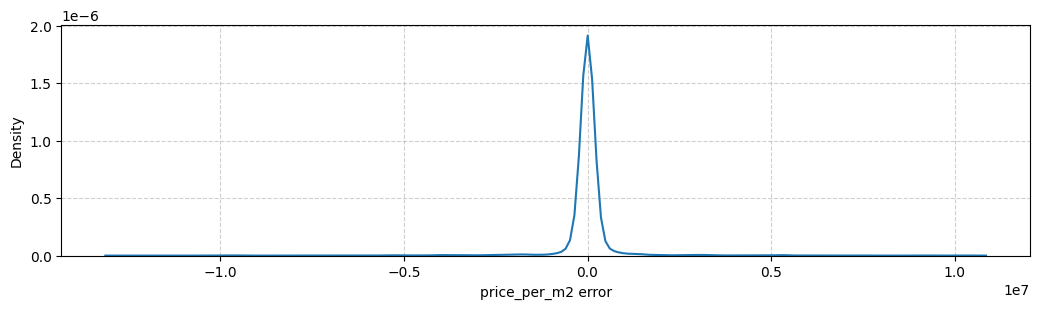

In [81]:
import seaborn as sns
import matplotlib.pyplot as plt

_, ax = plt.subplots(1,1, figsize=(12.5,3))
sns.kdeplot(ax=ax, data=val_error.reset_index(drop=True).sort_values())

plt.xlabel("price_per_m2 error")
plt.ylabel("Density")
plt.grid(True, alpha=0.6, linestyle="--")
plt.show()

In [82]:
Y_pred = model_cv.predict(X_test_scaled[300].reshape(1,15)) * 1e4
"{:,}".format(int(Y_pred[0])).replace(",", "."), "{:,}".format(int(Y_test[300])).replace(",", ".")

('4.034.309', '4.040.697')